In [6]:
# Data Handlers
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps

# Pytorch
import torch
import torch.nn as nn  # NN; networks (CNN, RNN, losses)
import torch.optim as optim  # Optimizers (Adam, Adadelta, Adagrad)
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, IterableDataset  # Dataset manager
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

# Other
import datetime
import os
from tqdm import tqdm
from pathlib import Path
from os import listdir
from fastaniso import anisodiff
from time import time


# Graphics
from matplotlib import pyplot as plt
import seaborn as sns
from skimage.metrics import structural_similarity as ssim


# Additional modules
from dataset_creator import generate_csv
from assistive_funcs import filtering_image, check_ssim, check_gmsd, convert_to_grayscale, get_dataset_name
from csv_dataloader import get_train_test_data
from math import floor

In [7]:
# Paths
p_main_data = Path("../data")
p_models = Path("../models")

p_scv_folder = p_main_data / "csv_files" # datasets_path
p_img = p_main_data / "images"

p_noised_imgs = p_main_data / "FC_imgs_with_noise"

p_filtered_images = p_main_data / "FC_filtered_images"

p_gray_images = p_main_data / "gray_images"

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"{dataset_name = }\n{device = }")
device

device(type='cuda')

In [9]:
# Dataset
win_size = 7
step = 3
create_dataset = 1
if create_dataset:
    generate_csv(win_size=win_size, dump_to_file=5000, step=step, force_create_dataset=1)

Borders were added, indexes were created. Passed time = 0.90s
Dataset created.               
Total spent time = 34.21s
Total samples = 408040
Dataset name 'W7_S3_L408040.csv'


In [10]:
win_size = 7
step = 3

dataset_name = get_dataset_name(win_size, step, p_scv_folder) #r"W5_S1_L3696640.csv"
dataset_name

'W7_S3_L408040.csv'

In [11]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# !unzip -q /content/gdrive/MyDrive/NIR/data/FC_data/W5_S5_L146410.zip

In [12]:
class DefaultModel(nn.Module):
    def __init__(self, in_len, out_len) -> None:
        super().__init__()
        self.in_len = in_len
        self.out_len = out_len
        self.hid_n = 20
        
        self.fcs = nn.Sequential(
            nn.Linear(self.in_len, self.in_len),
            nn.BatchNorm1d(self.in_len),
            nn.ReLU(),
            nn.Linear(self.in_len, self.hid_n * 2),
            nn.BatchNorm1d(self.hid_n * 2),
            nn.ReLU(),
            nn.Linear(self.hid_n * 2, self.hid_n * 2),
            nn.BatchNorm1d(self.hid_n * 2),
            nn.ReLU(),
            nn.Linear(self.hid_n * 2, self.hid_n),
            nn.BatchNorm1d(self.hid_n),
            nn.ReLU(),
            nn.Linear(self.hid_n, self.out_len),
        )

    def forward(self, x):
        x = self.fcs(x)
        return x

In [13]:
# Hyperparameters 
learning_rate = 0.01
num_epoches = 9
batch_size = 128


In [14]:
model = DefaultModel(in_len=(win_size ** 2), out_len=1).to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [15]:
losses = []
losses_append = losses.append

valid_losses = []
valid_losses_append = valid_losses.append

for epoch in range(num_epoches):
    model.train()
    train_loader, test_loader = get_train_test_data(scv_folder=p_scv_folder, dataset_name=dataset_name, batch_size=batch_size, train_size=0.8)
    for batch_ind, (data, targets) in tqdm(enumerate(train_loader)):
        # Data on cuda
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Forward
        scores = model(data) # Equal to model.forward(data)
        loss = criterion(scores, targets)
        if batch_ind % 3 == 0:
            losses_append(loss.item())
        # Backprop
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    model.eval()
    with torch.no_grad():
        for batch_ind, (data, targets) in tqdm(enumerate(test_loader)):
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            # Forward
            scores = model(data) # Equal to model.forward(data)
            loss = criterion(scores, targets)
            valid_losses_append(loss.item())

2550it [00:38, 67.07it/s]
638it [00:06, 100.32it/s]
2550it [00:36, 69.64it/s]
638it [00:06, 100.02it/s]
2550it [00:38, 66.45it/s]
638it [00:06, 96.24it/s] 
2550it [00:38, 65.73it/s]
638it [00:06, 91.87it/s]
2550it [00:37, 67.15it/s]
638it [00:06, 91.84it/s]
2550it [00:38, 65.86it/s]
638it [00:06, 93.42it/s]
2550it [00:39, 65.13it/s]
638it [00:06, 97.00it/s]
2550it [00:37, 68.85it/s]
638it [00:06, 104.00it/s]
2550it [00:36, 69.69it/s]
638it [00:06, 95.01it/s]


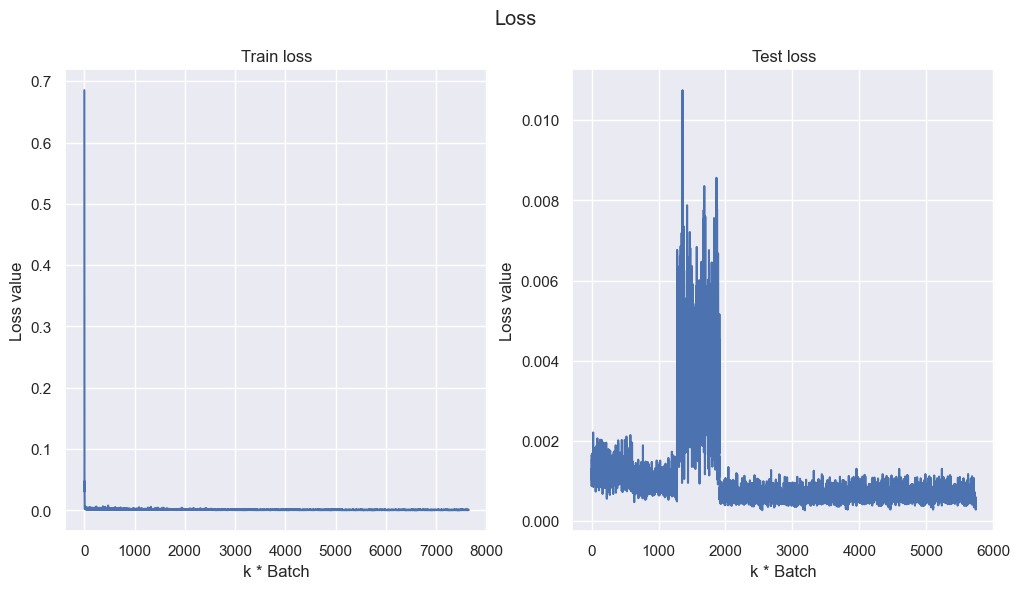

In [16]:
sns.set()
fig, (ax_train, ax_test) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Loss')

ax_train.set_title("Train loss")
ax_test.set_title("Test loss")

ax_train.set_ylabel('Loss value')
ax_test.set_ylabel('Loss value')

ax_train.set_xlabel("k * Batch")
ax_test.set_xlabel("k * Batch")

sns.lineplot(data=losses, ax=ax_train)
sns.lineplot(data=valid_losses, ax=ax_test)

plt.show()

In [17]:
list_images = listdir(p_noised_imgs)
for img_name in list_images:
    filtering_image(model, p_filtered_images, p_noised_imgs, img_name, win_size, device)

100%|██████████| 608/608 [00:01<00:00, 402.57it/s]


In [18]:
images_names = listdir(p_noised_imgs)
for name in images_names:
    check_ssim(p_filtered_images, p_gray_images, name)

1.jpg, SSIM = 0.888
10.jpg, SSIM = 0.898
2.jpg, SSIM = 0.903
3.jpg, SSIM = 0.878
4.jpg, SSIM = 0.895
5.jpg, SSIM = 0.858
6.jpg, SSIM = 0.904
7.jpg, SSIM = 0.933
8.jpg, SSIM = 0.898
9.jpg, SSIM = 0.878


In [19]:
images_names = listdir(p_noised_imgs)
for name in images_names:
    check_gmsd(p_filtered_images, p_gray_images, name)

1.jpg, GMSD = 0.044
10.jpg, GMSD = 0.063
2.jpg, GMSD = 0.040
3.jpg, GMSD = 0.062
4.jpg, GMSD = 0.053
5.jpg, GMSD = 0.060
6.jpg, GMSD = 0.037
7.jpg, GMSD = 0.052
8.jpg, GMSD = 0.043
9.jpg, GMSD = 0.069


In [ ]:
# p_img = p_raw_image / list_images[2]
# img_arr = np.array(ImageOps.grayscale(Image.open(p_img)))
# niters = [1, 2, 5, 10, 20]
# kappa = [1, 5, 10, 50, 100]
# for i in niters:
#     for k in kappa:
#         img_filtered = anisodiff(img_arr, niter=i, kappa=k)
#         img_filtered = img_filtered.astype(np.uint8)
#         Image.fromarray(img_filtered).save(f"{p_img}_I{i}_K{k}.jpg")